# Modeling For All Counties (LA, Orange, Ventura)

In [1]:
import warnings
warnings.filterwarnings("ignore")

#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import math

#Visualizing
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:.2f}'.format

#Acquire
from env import host, user, password 
import os
import acquire

#Prepare
import prepare

#SKLearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE


#Exploring
import explore

#Evaluate
import evaluate

## Data Acquisition

In [2]:
df = acquire.get_zillow_data(cached=True)
df.head()

,typeconstructiontypeid,storytypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,parcelid,id,basementsqft,bathroomcnt,...,taxdelinquencyyear,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
0,nan,nan,2.00,nan,nan,nan,10711855,1087254,nan,2.00,...,nan,60371132321007.00,-0.01,2017-07-07,NaN,NaN,NaN,Central,NaN,NaN
1,nan,nan,2.00,nan,nan,1.00,10711877,1072280,nan,2.00,...,nan,60371132321007.00,0.02,2017-08-29,Central,NaN,NaN,Central,NaN,NaN
2,nan,nan,2.00,nan,nan,1.00,10711888,1340933,nan,2.00,...,nan,60371132321007.00,0.08,2017-04-04,Central,NaN,NaN,Central,NaN,NaN
3,nan,nan,2.00,nan,nan,nan,10711910,1878109,nan,2.00,...,nan,60371132321008.00,-0.04,2017-03-17,NaN,NaN,NaN,Central,NaN,NaN
4,nan,nan,2.00,nan,nan,nan,10711923,2190858,nan,2.00,...,nan,60371132321008.00,-0.01,2017-03-24,NaN,NaN,NaN,Central,NaN,NaN


## Data Preparation

In [3]:
#Prepare the data using wrangle zillow 2
df = prepare.wrangle_zillow_2nd()
df.shape

(69305, 21)

## Data Exploration
(In main Notebook)

## Feature Engineering: SelectKBest**

In [4]:
#Split the Data
partitions = explore.split(df, target_var='logerror')
train = partitions[0]
partitions[0] = train

In [5]:
# the variables that need scaling
scaled_vars = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedfinishedsquarefeet', 'latitude', 'longitude',
       'rawcensustractandblock', 'regionidcity', 'regionidzip',
       'structuretaxvaluedollarcnt', 'landtaxvaluedollarcnt',
       'age', 'taxrate', 'acres']

# create new column names for the scaled variables by adding 'scaled_' to the beginning of each variable name 
scaled_column_names = ['scaled_' + i for i in scaled_vars]

# select the X partitions: [X_train, X_validate, X_test]
X = partitions[1:4]

# fit the minmaxscaler to X_train
X_train = X[0]
scaler = MinMaxScaler(copy=True).fit(X_train[scaled_vars])

def scale_and_concat(df):
    scaled_array = scaler.transform(df[scaled_vars])
    scaled_df = pd.DataFrame(scaled_array, columns=scaled_column_names, index=df.index.values)
    return pd.concat((df, scaled_df), axis=1)
for i in range(len(X)):
    X[i] = scale_and_concat(X[i])

In [6]:
#Define the other dataframes from partitions
X_validate = partitions[2]
X_test = partitions[3]
y_train = partitions[4]
y_validate = partitions[5] 
y_test = partitions[6]

In [7]:
X_train_scaled = X[0][['cola', 'hot_month_sale', 'has_heat', 'scaled_bathroomcnt',
       'scaled_bedroomcnt', 'scaled_buildingqualitytypeid',
       'scaled_calculatedfinishedsquarefeet', 'scaled_latitude',
       'scaled_longitude', 'scaled_rawcensustractandblock',
       'scaled_regionidcity', 'scaled_regionidzip',
       'scaled_structuretaxvaluedollarcnt', 'scaled_landtaxvaluedollarcnt',
       'scaled_age', 'scaled_taxrate', 'scaled_acres']]

In [8]:
#Create the kbest object
f_selector = SelectKBest(f_regression, k=5)

#Fit the kbest oject to the training data
f_selector = f_selector.fit(X_train_scaled, y_train)

#Return top 5 features

f_support = f_selector.get_support()
f_feature = X_train_scaled.iloc[:, f_support].columns.tolist()
f_feature

['cola',
 'scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip']

## Modeling

### Baseline Model

In [9]:
# 1. Predict logerror_pred_mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean

#Evaluate the baseline model using the mean
evaluate.baseline_mean_errors(y_train.logerror)

{'sse': 1065.2095152084285,
 'mse': 0.02744677957249236,
 'rmse': 0.16567069617917454}

In [10]:
# 2. compute logerror_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median

#Evaluate the baseline model using the median
evaluate.baseline_median_errors(y_train.logerror)

{'sse': 1069.7223934852557,
 'mse': 0.02756306089887286,
 'rmse': 0.16602126640546042}

**Takeaways:**<br>
    - The Mean Baseline Model peforms better than the Median Baseline Model<br>
    - The Mean Baseline Model is what we will move forward with as a metric for comparing our models

In [11]:
#Now that I have established the mean as the baseline, I will drop the median and rename baseline to yhat_baseline
y_train.drop(columns={'logerror_pred_median'}, inplace=True)

y_train.rename(columns={'logerror_pred_mean': 'yhat_baseline'}, inplace=True)

## Linear Regression Model

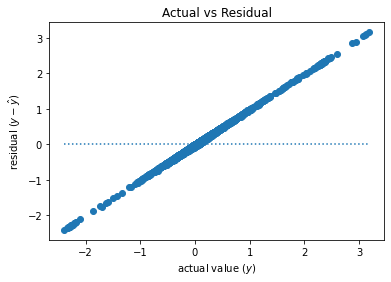

sse    1062.31
ess       2.90
tss    1065.21
mse       0.03
rmse      0.17
r^2       0.00
dtype: float64

In [12]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_scaled[['cola',
 'scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip']], y_train.logerror)

# predict train
y_train['yhat_lm'] = lm.predict(X_train_scaled[['cola',
 'scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_regionidzip']])

# compute residuals
y_train['residual'] = y_train['yhat_lm'] - y_train['logerror']
y_train['baseline_residual'] = y_train['yhat_baseline'] - y_train['logerror']

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.logerror, y_train.yhat_lm)

#Retrieve evaluation metrics for Linear Regression Model on in-sample data
evaluate.regression_errors(y_train.logerror, y_train.yhat_lm)

**Takeaways:**<br>
    - The Linear Regression Model Performs worse than baseline. Discard

## TweedieRegressorModel

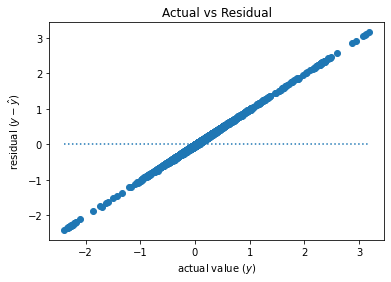

sse    1063.13
ess       2.08
tss    1065.21
mse       0.03
rmse      0.17
r^2       0.00
dtype: float64

In [13]:
# create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_structuretaxvaluedollarcnt',
 'scaled_acres'
]], y_train.logerror)

# predict train
y_train['yhat_glm'] = glm.predict(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_structuretaxvaluedollarcnt',
 'scaled_acres'
]])

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.logerror, y_train.yhat_glm)

#How does the GLM model perform on in-sample data?
evaluate.regression_errors(y_train.logerror, y_train.yhat_glm)

## Lasso & Lars Model

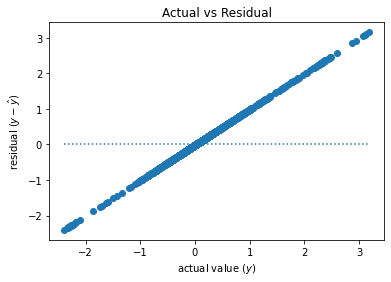

sse    1065.21
ess       0.00
tss    1065.21
mse       0.03
rmse      0.17
r^2       0.00
dtype: float64

In [14]:
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_structuretaxvaluedollarcnt',
 'scaled_acres']], y_train.logerror)

# predict train
y_train['yhat_lars'] = lars.predict(X_train_scaled[['scaled_bathroomcnt',
 'scaled_bedroomcnt',
 'scaled_calculatedfinishedsquarefeet',
 'scaled_structuretaxvaluedollarcnt',
 'scaled_acres']])

#Use evaluate model to visualize the residuals
evaluate.plot_residuals(y_train.logerror, y_train.yhat_lars)

#Retrieve evaluation metrics for Lasso + Lars Model on in-sample data
evaluate.regression_errors(y_train.logerror, y_train.yhat_lars)

### Takeaways:
- None of these models are performing significantly better than baseline